In [3]:
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

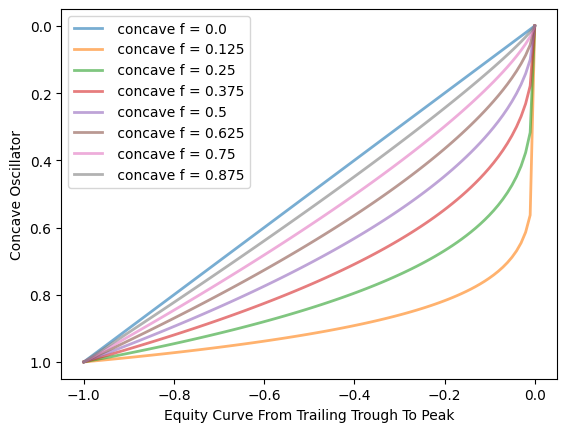

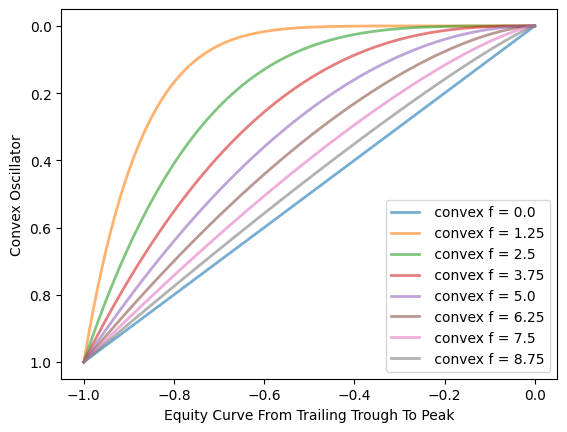

<Figure size 2000x800 with 0 Axes>

In [4]:
def concave(ddr, floor):
    '''
    For demo purpose only
    '''
    if floor == 0:
        concave = ddr
    else:
        concave = ddr ** (floor)
    return concave


# obtuse
def convex(ddr, floor):
    '''
    obtuse = 1 - acute
    '''
    if floor == 0:
        convex = ddr
    else:
        convex = ddr ** (1 / floor)
    return convex


# instantiate minimum Kapital
floor = np.arange(0, 1, 0.125)
# print('floor', floor)

x = -np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, f in enumerate(floor):
    y = concave(ddr=-x, floor=f)
    current_label = f' concave f = {f:.3}'
    ax.plot(x, y, linewidth=2, alpha=0.6, label=current_label)

ax.legend()
plt.ylabel('Concave Oscillator')
plt.xlabel('Equity Curve From Trailing Trough To Peak')
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

fig, ax = plt.subplots()
for i, f in enumerate(floor):
    y = convex(ddr=-x, floor=f)
    current_label = f' convex f = {f * 10:.3}'
    ax.plot(x, y, linewidth=2, alpha=0.6, label=current_label)
ax.legend()

plt.ylabel('Convex Oscillator')
plt.xlabel('Equity Curve From Trailing Trough To Peak')
ax.set_ylim(ax.get_ylim()[::-1])
plt.figure(figsize=(20, 8))
plt.show()

[*********************100%***********************]  1 of 1 completed


Index(['equity', 'peak_equity', 'tolerance', 'drawdown'], dtype='object')

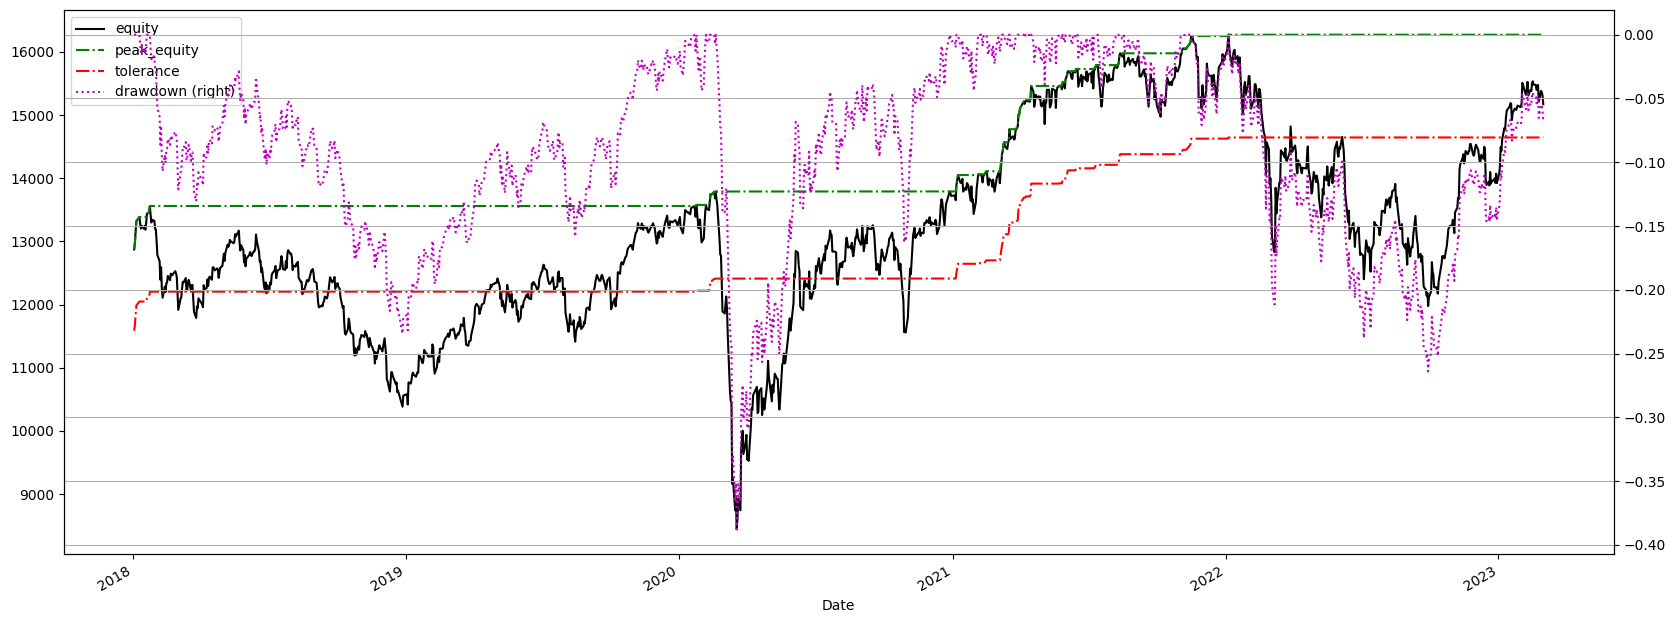

In [5]:
ticker = '^GDAXI'
dd_tolerance = -0.1

equity = pd.DataFrame()
start = '2017-12-31'
end = None
equity['equity'] = yf.download(tickers=ticker, start=start, end=end,
                               interval="1d", group_by='column',
                               auto_adjust=True, prepost=True,
                               threads=True, proxy=None)['Close']

equity['peak_equity'] = equity['equity'].cummax()
equity['tolerance'] = equity['peak_equity'] * (1 + dd_tolerance)
equity['drawdown'] = equity['equity'] / equity['equity'].cummax() - 1

equity.plot(style=['k', 'g-.', 'r-.', 'm:'],
            secondary_y=['drawdown'], figsize=(20, 8), grid=True)
equity.columns

In [6]:
def risk_appetite(eqty, tolerance, mn, mx, span, shape):
    """
    :param eqty: equity curve series
    :param tolerance: tolerance for drawdown (<0)
    :param mn: min risk
    :param mx: max risk
    :param span: exponential moving average to smoothe the risk_appetite
    :param shape: convex (>45 deg diagonal) = 1, concave (<diagonal) = -1, else: simple risk_appetite
    """

    # drawdown rebased
    eqty = pd.Series(eqty)
    watermark = eqty.expanding().max()
    # all-time-high peak equity
    drawdown = eqty / watermark - 1
    # drawdown from peak
    ddr = 1 - np.minimum(drawdown / tolerance, 1)
    # drawdown rebased to tolerance from 0 to 1
    avg_ddr = ddr.ewm(span=span).mean()
    # span rebased drawdown

    # Shape of the curve
    if shape == 1:  #
        _power = mx / mn  # convex
    elif shape == -1:
        _power = mn / mx  # concave
    else:
        _power = 1  # raw, straight line
    ddr_power = avg_ddr ** _power  # ddr

    # mn + adjusted delta
    risk_appetite = mn + (mx - mn) * ddr_power

    return risk_appetite

<Axes: xlabel='Date'>

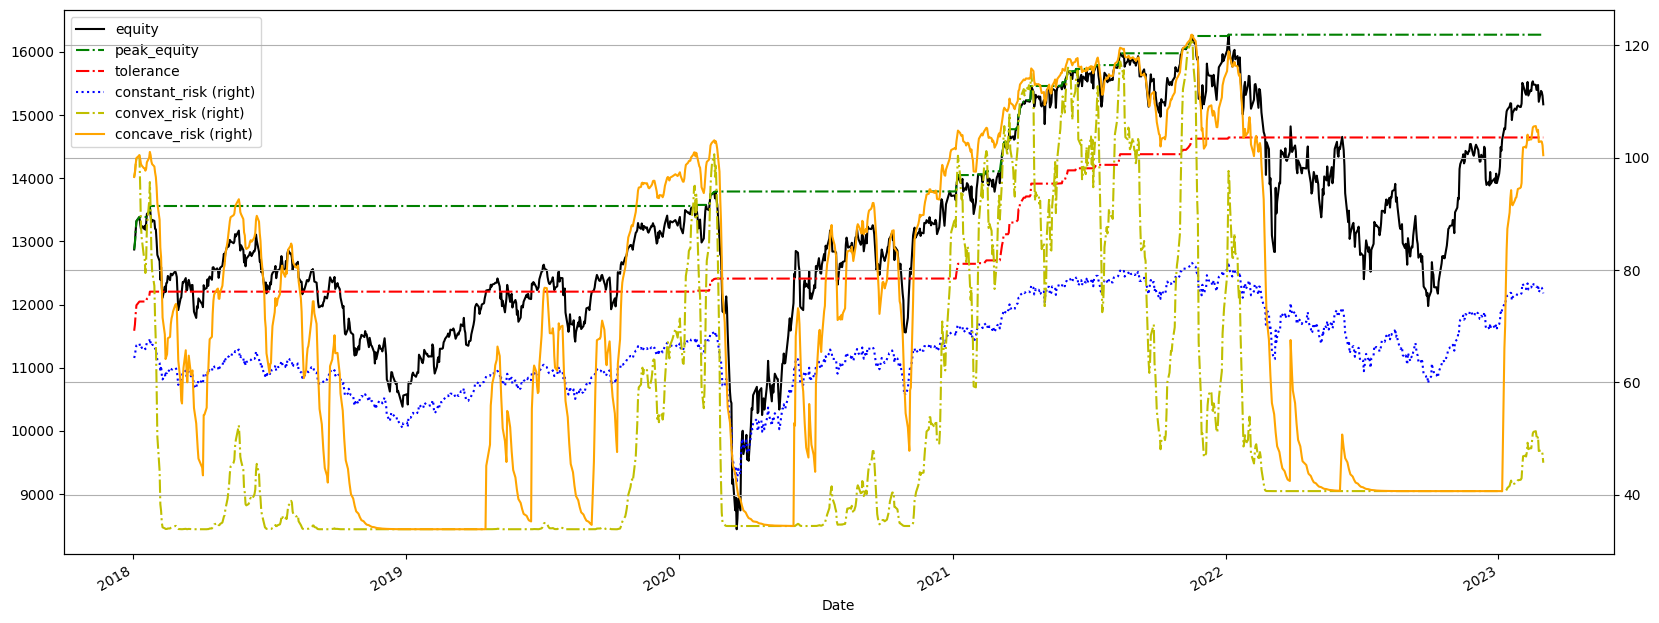

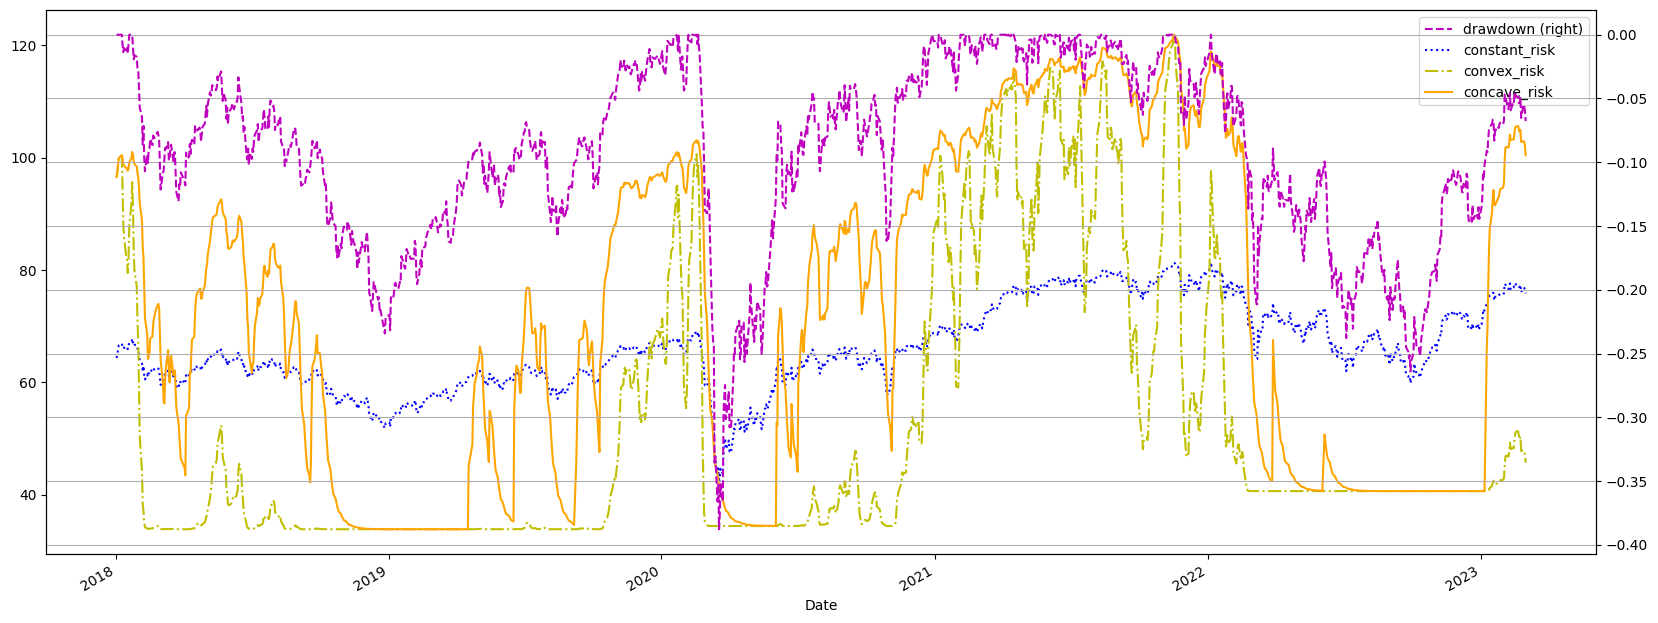

In [7]:
eqty = equity['equity']
tolerance = dd_tolerance
mn = -0.0025
mx = -0.0075
avg = (mn + mx) / 2
span = 5
shape = 1

equity['constant_risk'] = -equity['equity'] * avg
equity['convex_risk'] = -risk_appetite(eqty, tolerance, mn, mx, span, shape=1) * equity['peak_equity']
equity['concave_risk'] = -risk_appetite(eqty, tolerance, mn, mx, span, shape=-1) * equity['peak_equity']

equity[['equity', 'peak_equity', 'tolerance',
        'constant_risk', 'convex_risk', 'concave_risk']].plot(figsize=(20, 8),
                                                              grid=True,
                                                              secondary_y=['constant_risk', 'convex_risk',
                                                                           'concave_risk'],
                                                              style=['k', 'g-.', 'r-.', 'b:', 'y-.', 'orange'])

equity[['drawdown', 'constant_risk', 'convex_risk', 'concave_risk']].plot(grid=True,
                                                                          secondary_y=['drawdown'],
                                                                          style=['m--', 'b:', 'y-.', 'orange'],
                                                                          figsize=(20, 8))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': '9984.T Cumulative P&L Local & USD'}, xlabel='Date'>

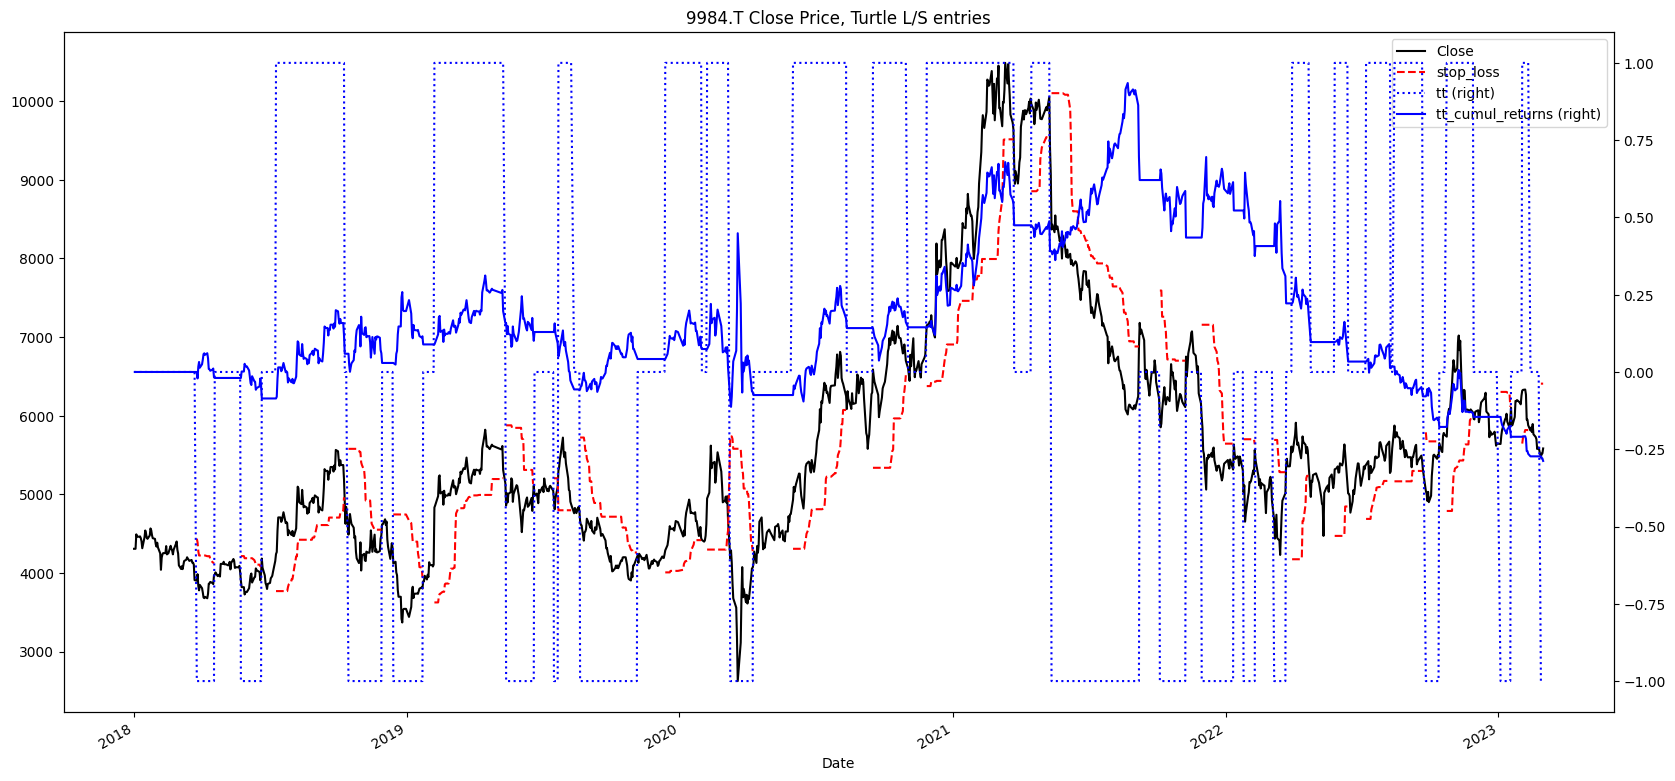

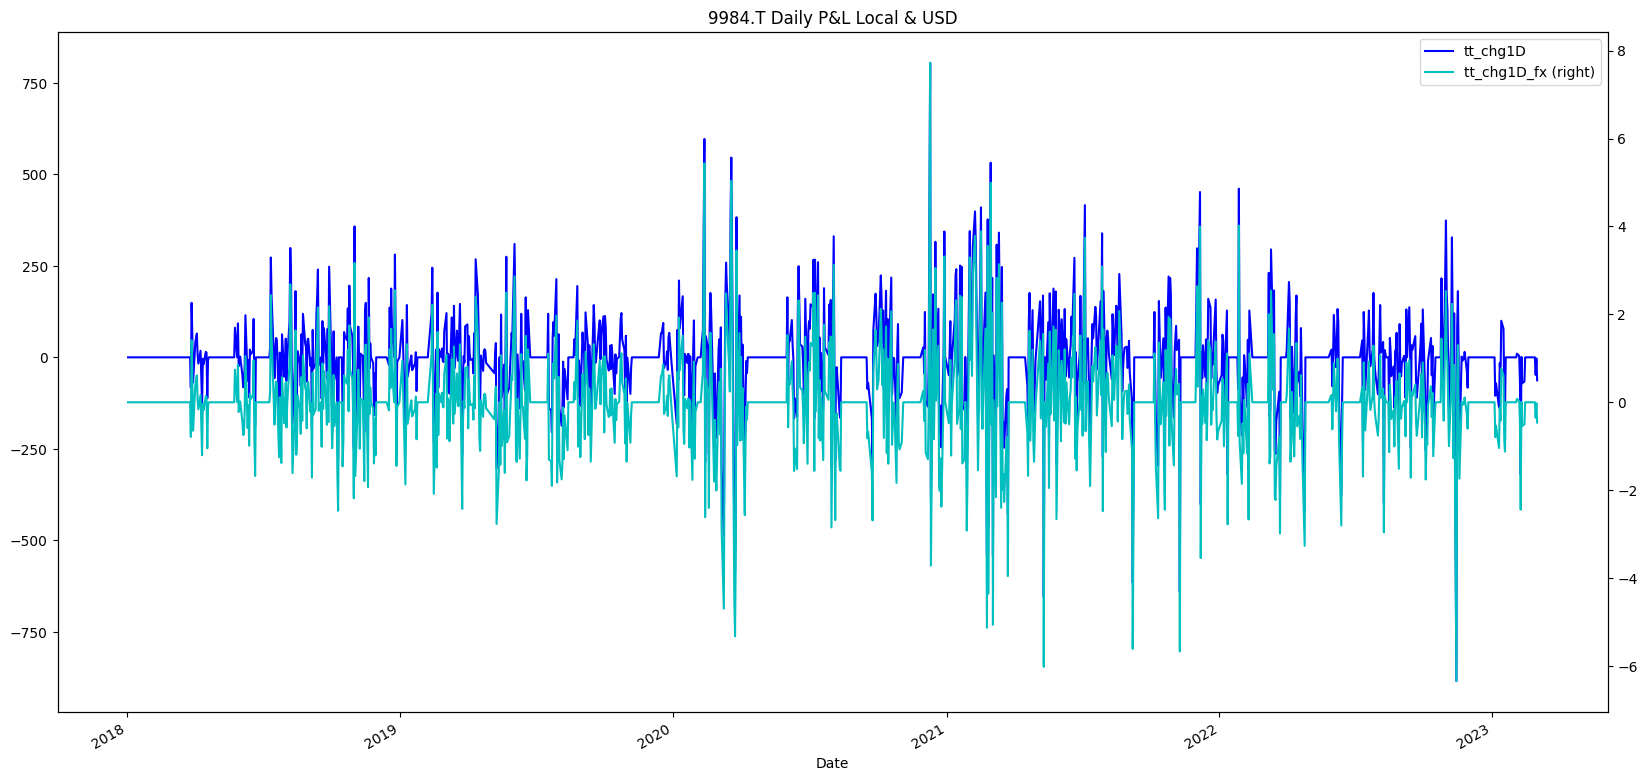

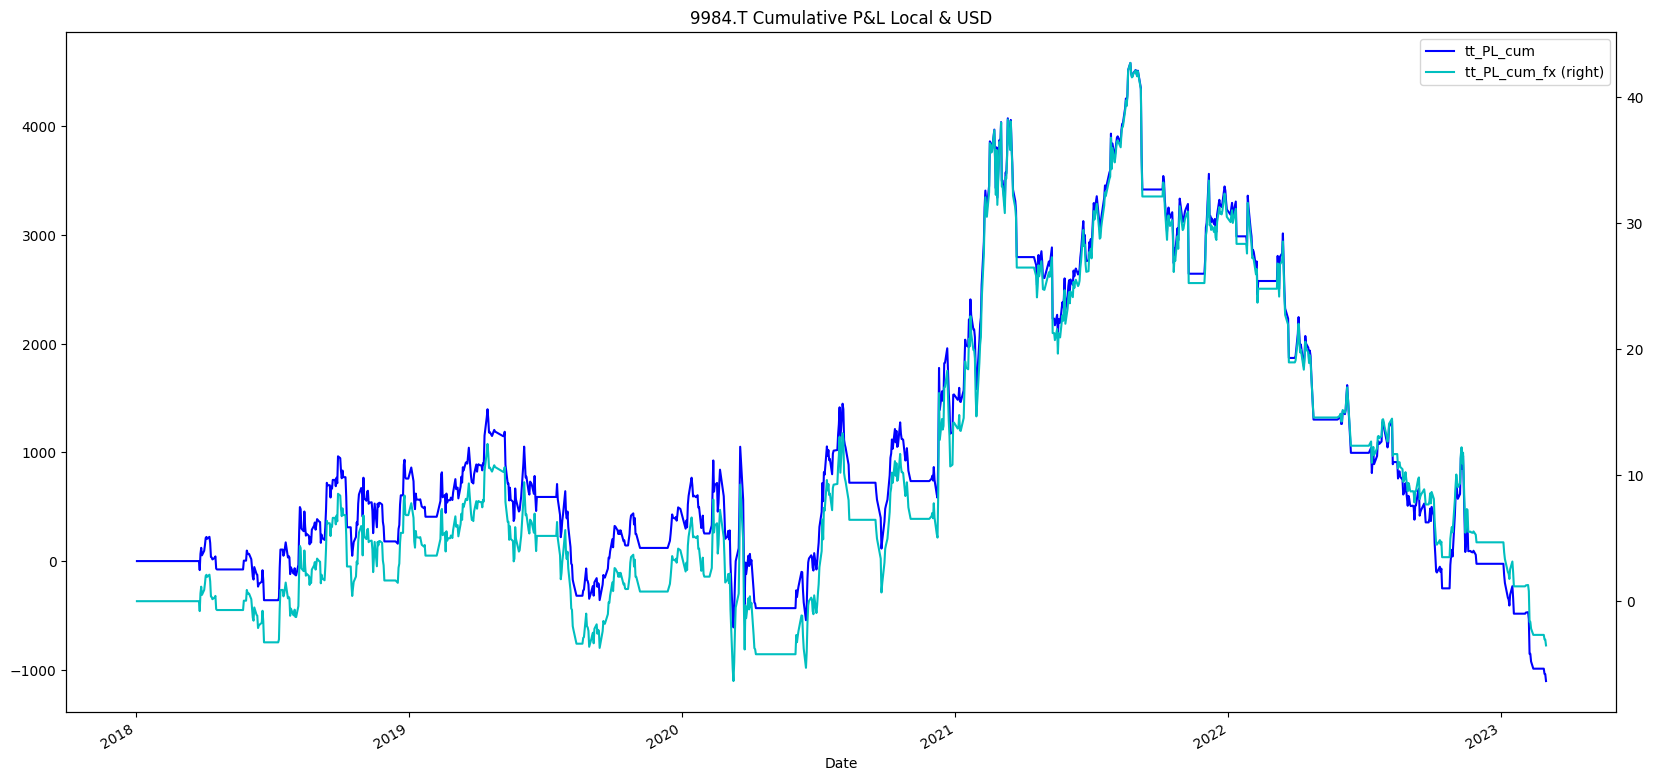

In [8]:
def regime_breakout(df, _h, _l, window):
    hl = np.where(df[_h] == df[_h].rolling(window).max(), 1,
                  np.where(df[_l] == df[_l].rolling(window).min(), -1, np.nan))
    roll_hl = pd.Series(index=df.index, data=hl).fillna(method='ffill')
    return roll_hl


def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df, _h, _l, window=slow)
    _fast = regime_breakout(df, _h, _l, window=fast)
    turtle = pd.Series(index=df.index,
                       data=np.where(_slow == 1, np.where(_fast == 1, 1, 0),
                                     np.where(_slow == -1, np.where(_fast == -1, -1, 0), 0)))
    return turtle


ticker = '9984.T'  # Softbank
start = '2017-12-31'
end = None
df = round(yf.download(tickers=ticker, start=start, end=end,
                       interval="1d", group_by='column', auto_adjust=True,
                       prepost=True, threads=True, proxy=None), 0)

ccy_ticker = 'USDJPY=X'
ccy_name = 'JPY'
ccy_df = np.nan

df[ccy_name] = round(yf.download(tickers=ccy_ticker,
                                 start=start,
                                 end=end,
                                 interval="1d",
                                 group_by='column',
                                 auto_adjust=True,
                                 prepost=True,
                                 threads=True,
                                 proxy=None)['Close'], 2)

df[ccy_name] = df[ccy_name].fillna(method='ffill')
slow = 50
fast = 20
df['tt'] = turtle_trader(df, _h='High', _l='Low', slow=slow, fast=fast)
df['tt_chg1D'] = df['Close'].diff() * df['tt'].shift()
df['tt_chg1D_fx'] = df['Close'].diff() * df['tt'].shift() / df[ccy_name]

df['tt_log_returns'] = np.log(df['Close'] / df['Close'].shift()) * df['tt'].shift()
df['tt_cumul_returns'] = df['tt_log_returns'].cumsum().apply(np.exp) - 1

df['stop_loss'] = np.where(df['tt'] == 1, df['Low'].rolling(fast).min(),
                           np.where(df['tt'] == -1, df['High'].rolling(fast).max(), np.nan))  # / df[ccy_name]
df['tt_PL_cum'] = df['tt_chg1D'].cumsum()
df['tt_PL_cum_fx'] = df['tt_chg1D_fx'].cumsum()

df[['Close', 'stop_loss', 'tt', 'tt_cumul_returns']].plot(secondary_y=['tt', 'tt_cumul_returns'],
                                                          figsize=(20, 10),
                                                          style=['k', 'r--', 'b:', 'b'],
                                                          title=str(ticker) + ' Close Price, Turtle L/S entries')

df[['tt_chg1D', 'tt_chg1D_fx']].plot(secondary_y=['tt_chg1D_fx'],
                                     figsize=(20, 10),
                                     style=['b', 'c'],
                                     title=str(ticker) + ' Daily P&L Local & USD')

df[['tt_PL_cum', 'tt_PL_cum_fx']].plot(secondary_y=['tt_PL_cum_fx'],
                                       figsize=(20, 10),
                                       style=['b', 'c'],
                                       title=str(ticker) + ' Cumulative P&L Local & USD')

In [9]:
def eqty_risk_shares(px, sl, eqty, risk, fx, lot):
    r = sl - px
    if fx > 0:
        budget = eqty * risk * fx
    else:
        budget = eqty * risk
    shares = round(budget // (r * lot) * lot, 0)
    #     print(r,budget,round(budget/r,0))
    return shares


px = 2000
sl = 2222

eqty = 100000
risk = -0.005
fx = 110
lot = 100

eqty_risk_shares(px, sl, eqty, risk, fx, lot)

-300.0

<Axes: title={'center': 'cumulative P&L, concave, convex, constant equity at risk, equal weight '}, xlabel='Date'>

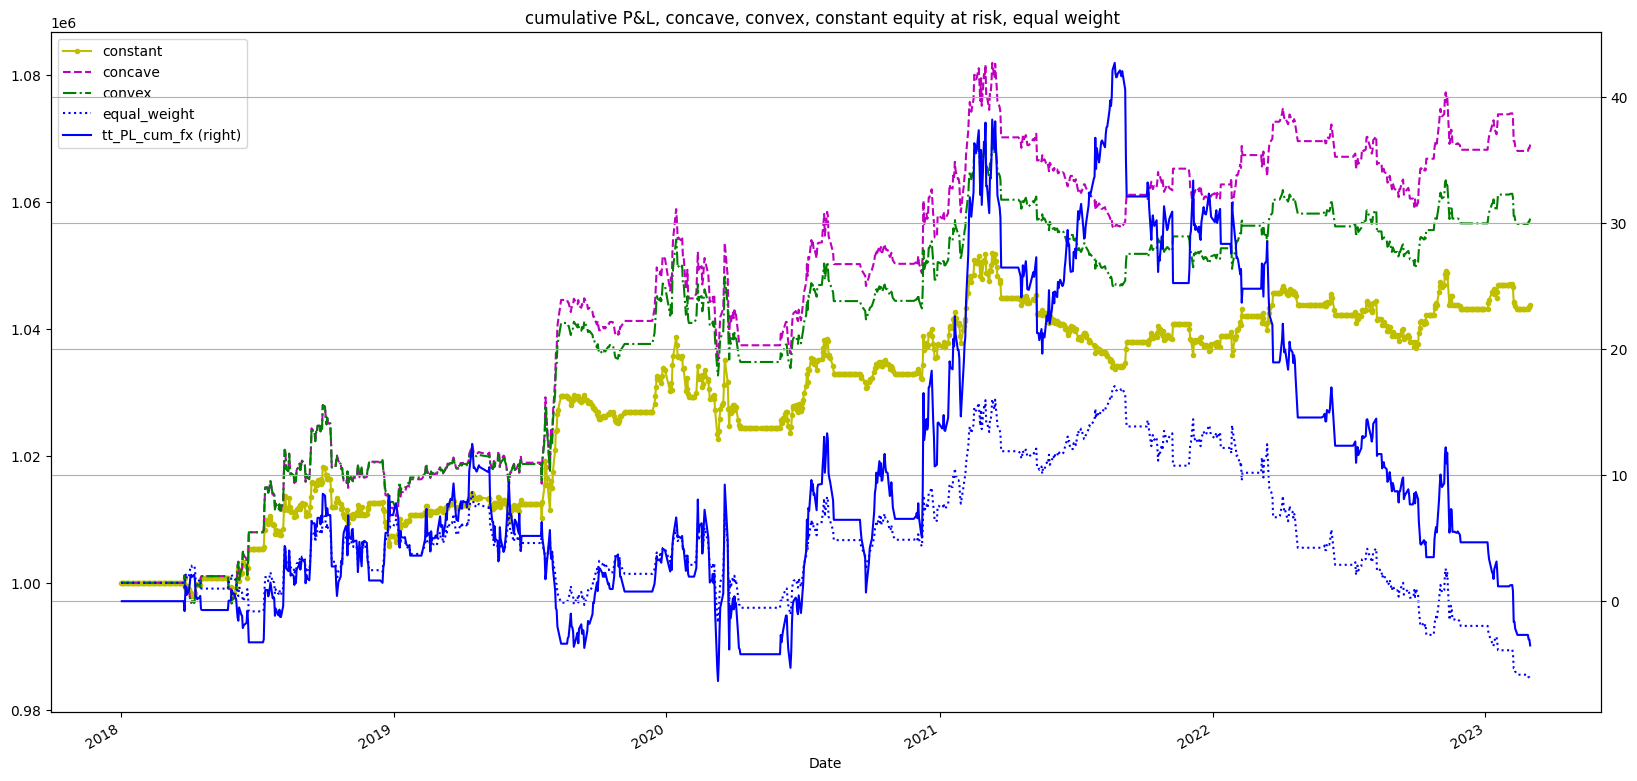

In [10]:
starting_capital = 1000000
lot = 100
mn = -0.0025
mx = -0.0075
avg = (mn + mx) / 2
tolerance = -0.1
equal_weight = 0.05
shs_fxd = shs_ccv = shs_cvx = shs_eql = 0
df.loc[df.index[0], 'constant'] = df.loc[df.index[0], 'concave'] = starting_capital
df.loc[df.index[0], 'convex'] = df.loc[df.index[0], 'equal_weight'] = starting_capital

for i in range(1, len(df)):
    df['equal_weight'].iat[i] = df['equal_weight'].iat[i - 1] + df['tt_chg1D_fx'][i] * shs_eql
    df['constant'].iat[i] = df['constant'].iat[i - 1] + df['tt_chg1D_fx'][i] * shs_fxd
    df['concave'].iat[i] = df['concave'].iat[i - 1] + df['tt_chg1D_fx'][i] * shs_ccv
    df['convex'].iat[i] = df['convex'].iat[i - 1] + df['tt_chg1D_fx'][i] * shs_cvx

    ccv = risk_appetite(eqty=df['concave'][:i], tolerance=tolerance,
                        mn=mn, mx=mx, span=5, shape=-1)
    cvx = risk_appetite(eqty=df['convex'][:i], tolerance=tolerance,
                        mn=mn, mx=mx, span=5, shape=1)

    if (df['tt'][i - 1] == 0) & (df['tt'][i] != 0):
        px = df['Close'][i]
        sl = df['stop_loss'][i]
        fx = df[ccy_name][i]
        shs_eql = (df['equal_weight'].iat[i] * equal_weight * fx // (px * lot)) * lot
        if px != sl:
            shs_fxd = eqty_risk_shares(px, sl, eqty=df['constant'].iat[i],
                                       risk=avg, fx=fx, lot=100)
            shs_ccv = eqty_risk_shares(px, sl, eqty=df['concave'].iat[i],
                                       risk=ccv[-1], fx=fx, lot=100)
            shs_cvx = eqty_risk_shares(px, sl, eqty=df['convex'].iat[i],
                                       risk=cvx[-1], fx=fx, lot=100)

df[['constant', 'concave', 'convex', 'equal_weight', 'tt_PL_cum_fx']].plot(figsize=(20, 10), grid=True,
                                                                           style=['y.-', 'm--', 'g-.', 'b:', 'b'],
                                                                           secondary_y='tt_PL_cum_fx',
                                                                           title='cumulative P&L, concave, convex, constant equity at risk, equal weight ')

In [11]:
def pyramid(position, root=2):
    '''
    position is the number of positions
    power is root n.
    Conservative = 1, aggressive = position, default = 2
    '''
    return 1 / (1 + position) ** (1 / root)


def amortized_weight(raw_weight, amortization):
    '''
    raw_weight is the initial position size
    amortization is pyramid(position,root=2)
    '''
    return raw_weight * amortization


weight = 0.05
position = np.arange(1, 4)
print('position', position)
print('linear', pyramid(position, root=1) * weight)
print('square root', pyramid(position, root=2) * weight)
print('position n', pyramid(position, root=position) * weight)

position [1 2 3]
linear [0.025      0.01666667 0.0125    ]
square root [0.03535534 0.02886751 0.025     ]
position n [0.025      0.02886751 0.03149803]
